# This file used for training model

In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import os
import random
import pandas as pd 
import numpy as np 
import time 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from PIL import Image

In [2]:
# Transform input image and reshape to (224, 224)
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0,), (1,))])

### Let's start from show dataset

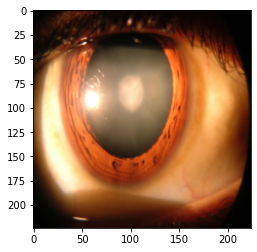

In [3]:
Img = datasets.ImageFolder('./', transform=transform)
Img = Img[1000][0]
Img = Img.permute(1, 2, 0).numpy()
plt.imshow(Img)
plt.show()

# Create class to group images and their class into tuple (img, label)

In [4]:
class Put_Class(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform
        
    def __len__(self): 
        return self.len
    
    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)

        if   'Normal'     in path:
            label = 0
        elif 'Cataract'   in path:
            label = 1
        elif 'Pinguecula' in path:
            label = 2
        elif 'Pterygium'  in path:
            label = 3
        
        return (image, label)

In [5]:
dir1 = os.path.join('_Dataset')
dir2 = os.path.join('Test_')

img_files = os.listdir(dir1)
img_file_test = os.listdir(dir2)

def train_path(_p):
    return os.path.join(dir1,_p)
def test_path(_p):
    return os.path.join(dir2,_p)

img_files      = list(map(train_path, img_files))
img_files_test = list(map(test_path, img_file_test))
# print(img_files_test)

print('Number of images [Training set + Validation set] :', len(img_files))
print('Number of images [Test set]                      :', len(img_files_test))

random.shuffle(img_files)
train_files = img_files[:int(0.8 * len(img_files))]


## Set 80 percent for training set and 20 for validation set ##
valid = img_files[int(0.8 * len(img_files)):]
test  = img_files_test

Number of images [Training set + Validation set] : 4000
Number of images [Test set]                      : 54


### Prepare data for training model

In [6]:
train_ds = Put_Class(train_files, transform)
train_dl = DataLoader(train_ds, batch_size=10)
len(train_ds), len(train_dl)

(3200, 320)

In [7]:
valid_ds = Put_Class(valid, transform)
valid_dl = DataLoader(valid_ds, batch_size=10)
len(valid_ds), len(valid_dl)

(800, 80)

In [8]:
test_ds = Put_Class(test, transform)
test_dl = DataLoader(test_ds, batch_size=10)
len(test_ds), len(test_dl)

(54, 6)

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,  out_channels = 48, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 48, out_channels = 24, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 24, out_channels = 64, kernel_size=(3, 3), padding=1)
        self.fc1 = nn.Linear(in_features= 64 * 6 * 6, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.fc3 = nn.Linear(in_features= 50, out_features=4)  
        
    def forward(self, X):
        
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
#       -------------------------
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
#       -------------------------      
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)
#       -------------------------
        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))
#       -------------------------
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
#       -------------------------    
        return F.log_softmax(X)

In [10]:
if torch.cuda.is_available():
    print("GPU Supported")
else:
    print("GPU Not Supported")

GPU Supported


In [11]:
model = Network().cuda(3)
loss_fn = nn.CrossEntropyLoss()   #-> for softmax
# loss_fn = nn.BECLoss()   #-> for sigmoid
# loss_fn = nn.MSELoss()   #-> for linear

### Use Adam to optimize because it better than SGD...
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [12]:
history = pd.DataFrame()
losses = []
accuracies = []
epoches = 20
start = time.time()
for epoch in range(epoches):
    epoch_loss = 0
    epoch_accuracy = 0
    for X, y in train_dl:
        X = X.cuda(3)
        y = y.cuda(3)
        preds = model(X)
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        
    epoch_accuracy = epoch_accuracy/len(train_dl)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dl)
    losses.append(epoch_loss)
    print("Epoch: {}, train loss: {:.4f}, train accracy: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))


    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_accuracy = 0
        for val_X, val_y in valid_dl:
            val_X = val_X.cuda(3)
            val_y = val_y.cuda(3)
            val_preds = model(val_X)
            val_loss = loss_fn(val_preds, val_y)

            val_epoch_loss += val_loss            
            val_accuracy = ((val_preds.argmax(dim=1) == val_y).float().mean())
            val_epoch_accuracy += val_accuracy
        val_epoch_accuracy = val_epoch_accuracy/len(valid_dl)
        val_epoch_loss = val_epoch_loss / len(valid_dl)
        print("Epoch: {}, valid loss: {:.4f}, valid accracy: {:.4f}, time: {}\n".format(epoch, val_epoch_loss, val_epoch_accuracy, time.time() - start))
        history = history.append(dict(epoch= epoch, training_loss=epoch_loss, training_acc=epoch_accuracy, val_loss=val_epoch_loss, val_acc=val_epoch_accuracy), ignore_index=True)

Epoch: 0, train loss: 0.9592, train accracy: 0.5747, time: 49.37962865829468
Epoch: 0, valid loss: 0.6566, valid accracy: 0.7125, time: 60.501906394958496

Epoch: 1, train loss: 0.5776, train accracy: 0.7609, time: 94.57889103889465
Epoch: 1, valid loss: 0.4750, valid accracy: 0.8263, time: 101.78866219520569

Epoch: 2, train loss: 0.3773, train accracy: 0.8625, time: 139.70083594322205
Epoch: 2, valid loss: 0.3964, valid accracy: 0.8450, time: 146.34018301963806

Epoch: 3, train loss: 0.2956, train accracy: 0.8881, time: 184.23369908332825
Epoch: 3, valid loss: 0.3772, valid accracy: 0.8575, time: 191.1349799633026

Epoch: 4, train loss: 0.2275, train accracy: 0.9159, time: 229.74008965492249
Epoch: 4, valid loss: 0.3499, valid accracy: 0.8825, time: 236.65262508392334

Epoch: 5, train loss: 0.1899, train accracy: 0.9300, time: 273.85608196258545
Epoch: 5, valid loss: 0.4069, valid accracy: 0.8688, time: 281.2519462108612

Epoch: 6, train loss: 0.1596, train accracy: 0.9416, time: 320

In [34]:
def predict(test_dl, plot = True):
    
    val_epoch_accuracy = 0
    for X_test, y_test in test_dl:
        X_test = X_test.cuda(3) if torch.cuda.is_available() else X_test
        y_test = y_test.cuda(3) if torch.cuda.is_available() else y_test
        y_preds = model(X_test)

        val_accuracy = ((y_preds.argmax(dim=1) == y_test).float().mean())
        val_epoch_accuracy += val_accuracy
        x = X_test.cpu() if torch.cuda.is_available() else X_test
        x = x.permute(0, 2, 3, 1).numpy()
        y = y_preds.argmax(dim=1).cpu().numpy()
        z = ['Normal', 'Cataract', 'Pinguecula', 'Pterygium']
        
        if plot == True:
            plt.figure(figsize=(18, 18))
            for i in range(len(X_test)):
                plt.subplot(301 + 5*10 +(i%5))
                plt.imshow(x[i])

                for j in range(4):    
                    if y[i] == j:
                        if y[i] == (y_test[i].cpu().numpy()):    
                            plt.title(z[j] ,fontsize=20, color = 'green')
                        else:
                            plt.title(z[j] ,fontsize=20, color = 'red')
            plt.show()
            
    val_epoch_accuracy = val_epoch_accuracy/len(test_dl)
    print("Accuracy : %.2f" %val_epoch_accuracy.cpu().numpy())

### Show outcome of model
    Green means that model predicts correct.
    
    Red means that model predicts wrong.

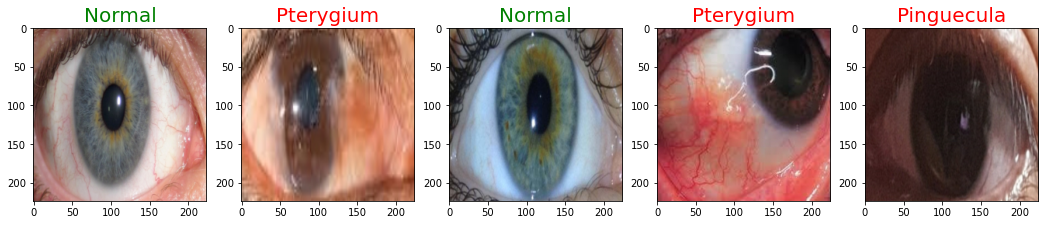

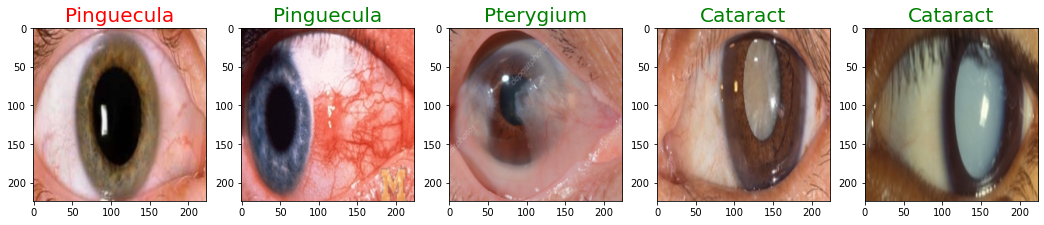

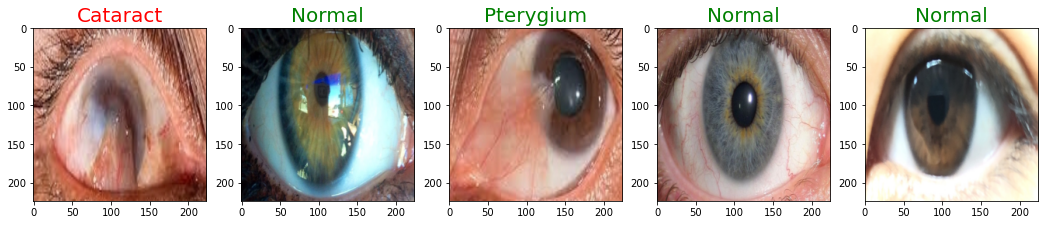

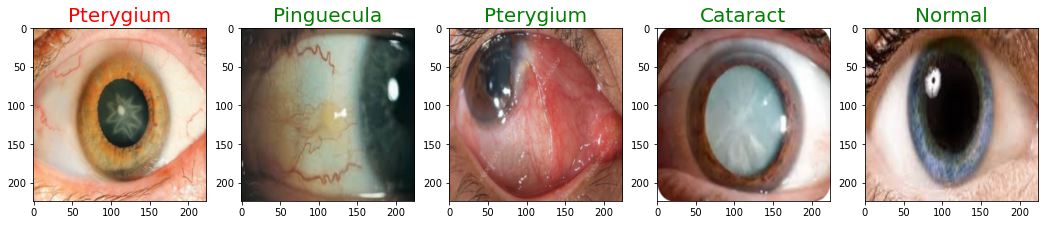

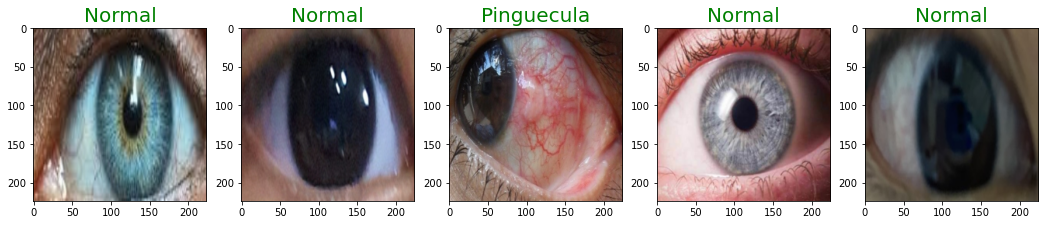

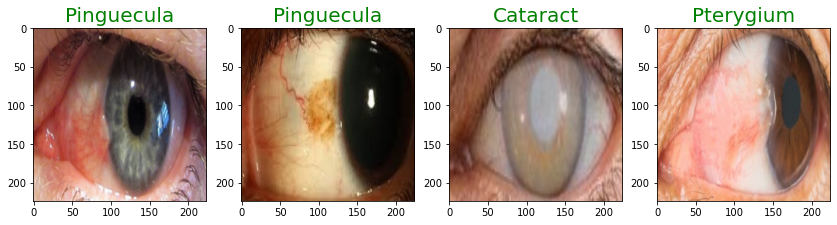

Accuracy : 0.82


In [35]:
predict(test_dl, plot = True)

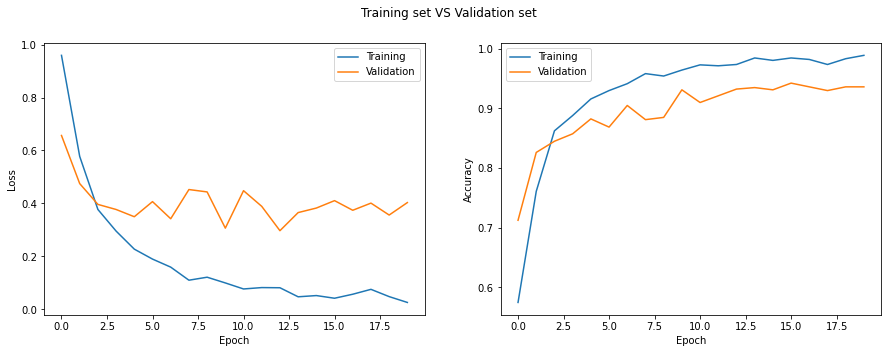

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

fig.suptitle('Training set VS Validation set')
ax1.plot(history.epoch, history.training_loss, label='Training')
ax1.plot(history.epoch, history.val_loss, label='Validation')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc ='best')



ax2.plot(history.epoch, history.training_acc, label='Training')
ax2.plot(history.epoch, history.val_acc, label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc ='best')
plt.show()

### Save model for predict later

In [39]:
torch.save(model.state_dict(), "./Save Model/Real.pth")